In [1]:
%load_ext autoreload
%autoreload 1
import numpy as np
import scipy.sparse
from matplotlib import pyplot as plt
import polars as pl
from polars import col

import implicit
from implicit.gpu.als import AlternatingLeastSquares
from implicit.evaluation import train_test_split, ranking_metrics_at_k

from prelib import data_dir
%aimport e6db.utils.polars
%aimport e6db.utils.numpy
from e6db.utils.polars import filter_tag_list
from e6db.utils.numpy import  tags_to_scipy_csr

# Dataset filtering

First, filter out the tags that don't get enough use. Since tags are sorted, we can find the rank / vocabulary size that represents a given percentile of all tagging relations:

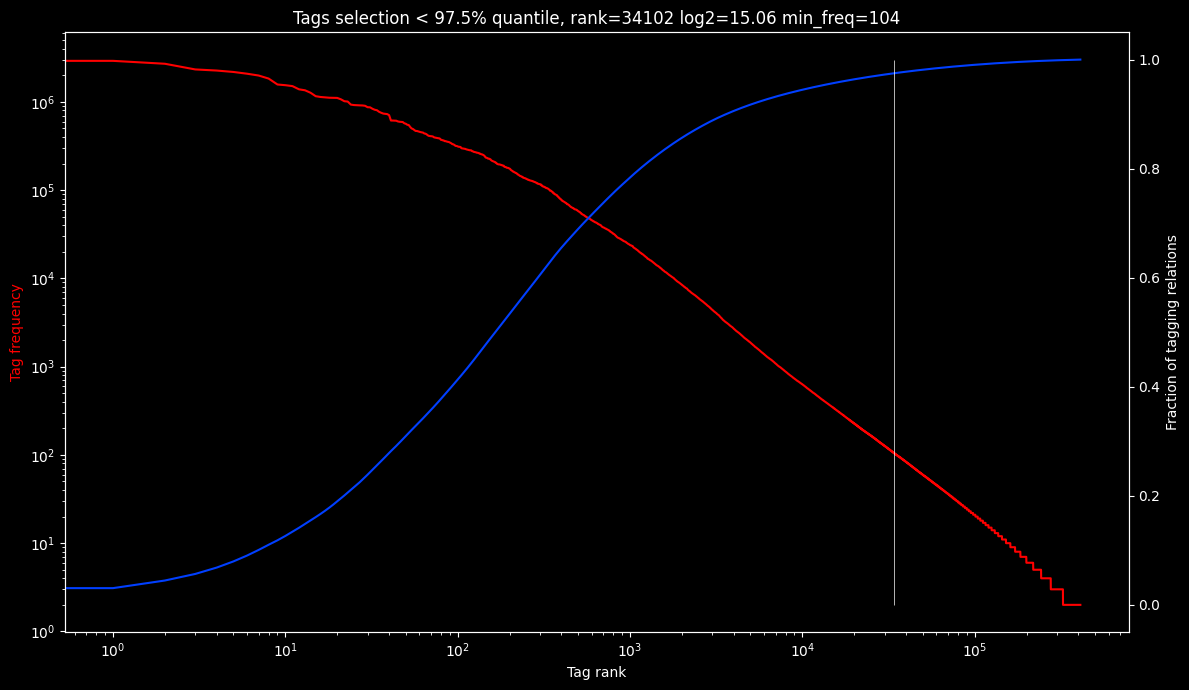

In [2]:
df = (
    pl.scan_parquet(data_dir / 'tags.parquet')
    .select('freq', frac=col('freq').cum_sum())
    .with_columns(col('frac') / col('frac').last())
).collect()


tresh_quantile = 0.975
thresh_idx = df['frac'].search_sorted(tresh_quantile)

f, ax1 = plt.subplots(1, 1, figsize=(12,7))
ax1.set_title(f'Tags selection < {1e2*tresh_quantile:.1f}% quantile, rank={thresh_idx} log2={np.log2(thresh_idx):.2f} min_freq={df[thresh_idx, 'freq']}')
ax1.set_xlabel('Tag rank')

ax1.plot(df['freq'], color='red')
ax1.set_yscale('log')
ax1.set_ylabel('Tag frequency', color='red')

ax12 = ax1.twinx()
ax12.semilogx(df['frac'])
ax12.set_ylabel('Fraction of tagging relations')
ax12.vlines([thresh_idx], [0], [1], linewidth=0.5);

Lets round the vocabulary size to $2^{15}$.

The we find a lower threshold of direct tags per post to encompoass a percentile of the dataset.

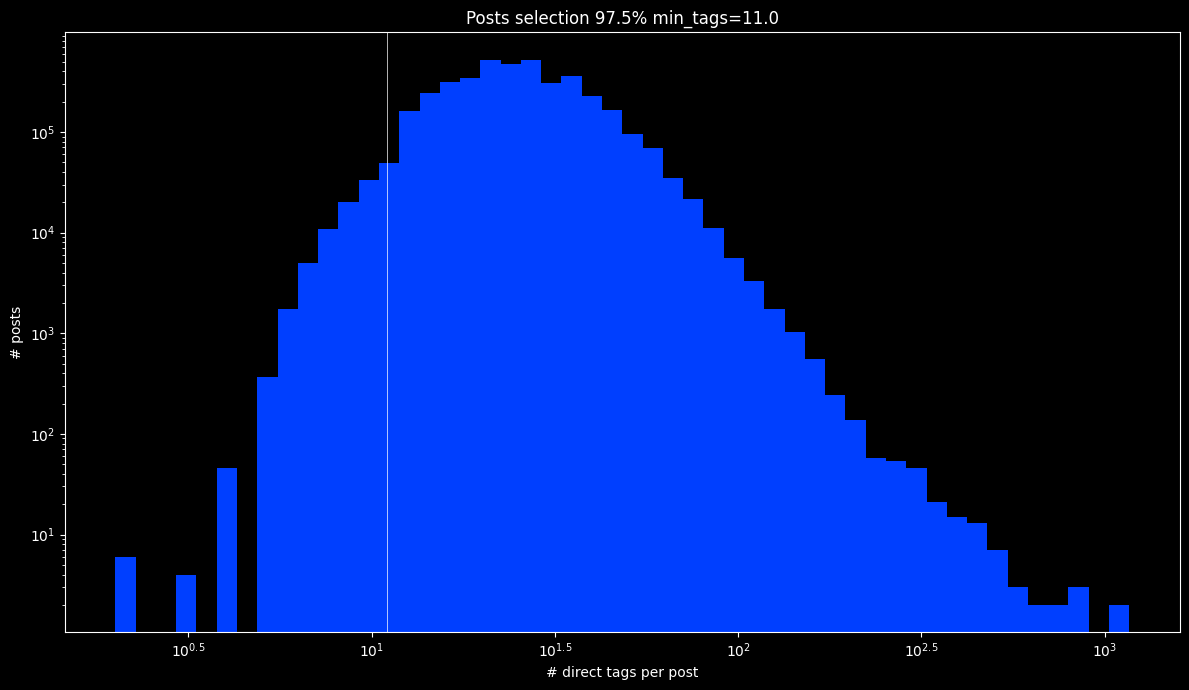

In [3]:
N_vocab = 1 << 15

df = (
    pl.scan_parquet(data_dir / 'posts.parquet')
    .select(tag_count=filter_tag_list('stripped_tags', N_vocab).list.len())
    .collect()['tag_count']
)

tresh_quantile = 0.975
thresh = np.quantile(df, 1. - tresh_quantile)


f, ax1 = plt.subplots(1, 1, figsize=(12,7))
ax1.set_title(f'Posts selection {1e2*tresh_quantile:}% min_tags={thresh}')
ax1.hist(df.log10(), bins=50, log=True);

#xs = np.linspace(df.min(), df.max(), 6, endpoint=True)
xs = ax1.get_xticks()
ax1.set_xticks(xs, [f'$10^{{{x:g}}}$' for x in xs]);
ax1.set_xlabel('# direct tags per post')
ax1.set_ylabel('# posts')
ax1.vlines([np.log10(thresh)], [0], [ax1.get_ylim()[1]], linewidth=0.5);

Finally, load and filter the dataset, and construct a sparse interaction matrix.

In [4]:
N_vocab = 1 << 15
min_tags = 11

# N_vocab = 1 << 11
# min_tags = 32

df = (
    pl.scan_parquet(data_dir / 'posts.parquet')
    .select('id', filter_tag_list('stripped_tags', N_vocab), filter_tag_list('implied_tags', N_vocab))
    .filter(col('stripped_tags').list.len() >= min_tags)
    .select('id', all_tags=pl.concat_list('stripped_tags', 'implied_tags'))
    .collect()
)

interactions = tags_to_scipy_csr(df, vocab_size=N_vocab, column='all_tags')
post_ids = df['id'].to_numpy()
#del df

interactions.check_format()
interactions.shape

(3934432, 32768)

# Alternating Least Square

The [Alternating Least Square](https://web.stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf) method is an algorithm factorizing a matrix, here our `[posts, tags]` interaciton matrix.
It succesively optimizes the reduced matrices for posts and tags by alternating between the two problems, optimizing one matrix while keeping the other constant.

The `implicit` library provides CUDA kernels for this algorithm.

The hyperparamters used here produce okay results, but haven't been thoroughly optimized. 

*FIXME*: Why does increasing the iterations count produces worse results? Increasing the l2 regularization doesn't help.

In [5]:
seed = 0

# R_train, R_test = train_test_split(interactions, random_state=seed)
R_train = interactions

als_kwargs = dict(
    factors=256,
    regularization=0.02,
    iterations=15,
    alpha = 1,
    calculate_training_loss=True,
    random_state=seed
)

model = AlternatingLeastSquares(**als_kwargs)

idf = np.log(R_train.shape[0]) - np.log1p(R_train.sum(axis=0))
tfidf_R_train = R_train.multiply(idf.reshape(1, -1))

model.fit(scipy.sparse.csr_matrix(tfidf_R_train))

  0%|          | 0/15 [00:00<?, ?it/s]

In [98]:
implicit.evaluation.ranking_metrics_at_k(model, R_train, R_test, K=8)

  0%|          | 0/583846 [00:00<?, ?it/s]

{'precision': 0.5522338941048379,
 'map': 0.4622241616768615,
 'ndcg': 0.6110172084916301,
 'auc': 0.6522376466847226}

In [6]:
import safetensors.numpy
safetensors.numpy.save_file(
    dict(tag_factors=model.item_factors.to_numpy()),
    data_dir / 'implicit_tag_factors.safetensors'
)

safetensors.numpy.save_file(
    dict(post_factors=model.user_factors.to_numpy(),
         post_ids=post_ids
        ),
    data_dir / 'implicit_post_factors.safetensors'
)

# t-SNE Viz

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE()
Xt2 = tsne.fit_transform(model.item_factors.to_numpy())

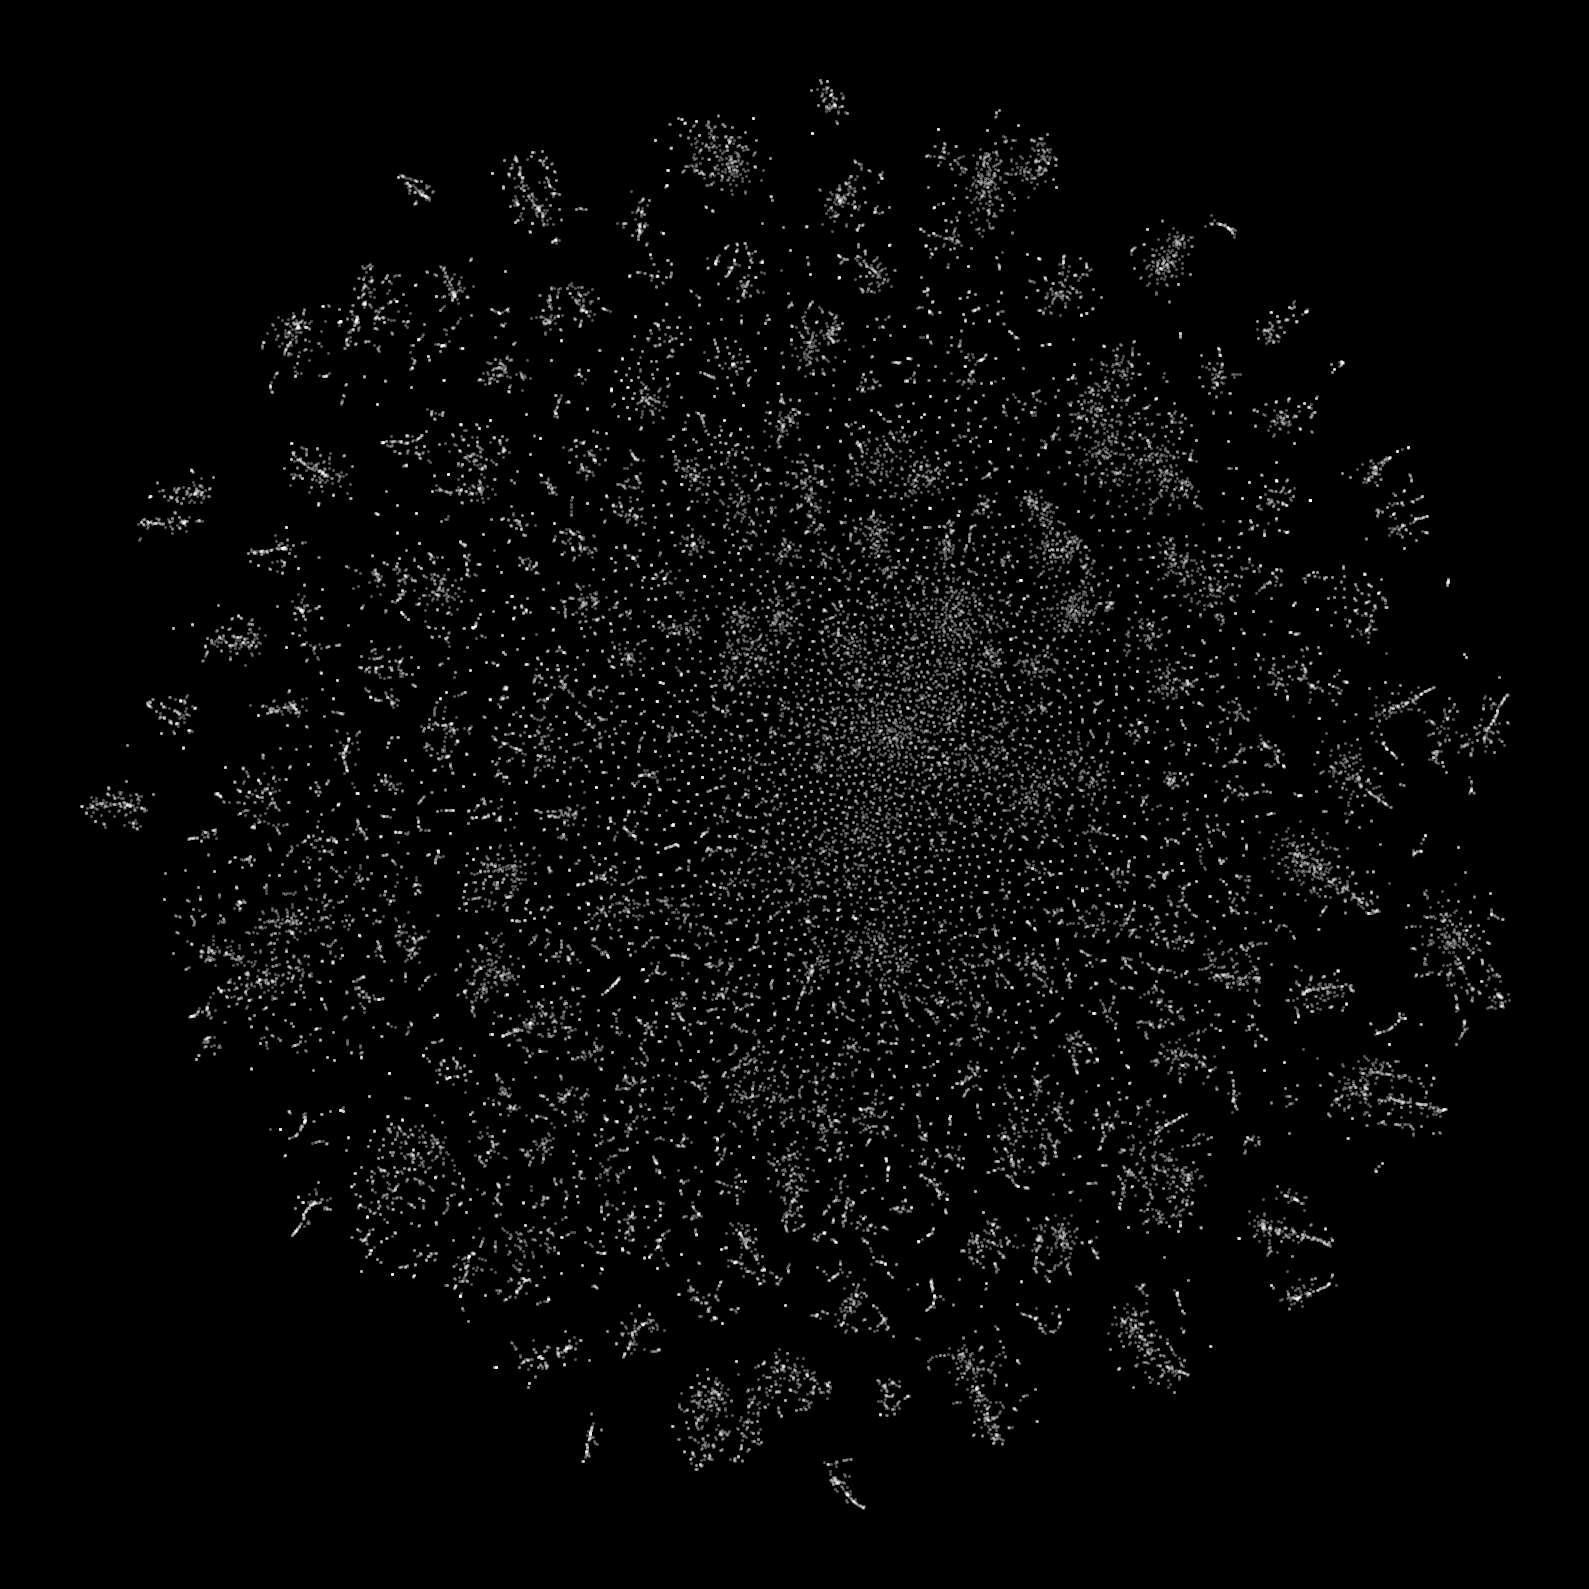

In [8]:
plt.figure(figsize=(16,16))
plt.axis('off')
plt.scatter(
    *Xt2.T,
    linewidth=0,
    color='white',
    s=5,
    alpha=1/3
)